<a href="https://colab.research.google.com/github/iamabd53/Book_Recommendation_system/blob/main/Book_Recommendation_system_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b>Project Title : Book Recommendation System
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.


**Content**



The Book-Crossing dataset comprises 3 files.


**Users**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.


**Books**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title,Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.


**Ratings**

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import random

#<b> Importing Data Frame

In [ ]:
books = pd.read_csv("/content/drive/MyDrive/ML project ALMA better/Books.csv")

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/ML project ALMA better/Users.csv")

#<b> Data preprocessing

##<b> Books Data Frame

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
#Shape of Books Data Frame
books.shape

(271360, 8)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
# Checking Null Values
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [ ]:
# droping Null Values
books.dropna(inplace=True)

In [ ]:
# shape of dataframe after droping null values
books.shape

(271354, 8)

In [ ]:
# DataFrame columns
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [ ]:
# Checking Duplicate Data
books.duplicated().sum()

0

In [ ]:
# unique publication dates
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'



1.   All the data in object type but year of publication must be in integers
2.   some of 'year of publication' date are 0 so we have to take some action on it
3.  There are some values above 2021 in "year of publication" so we have to take care of these values also.



In [ ]:
# converting dtype of Year of publication from object to integer
books['Year-Of-Publication']=books['Year-Of-Publication'].astype("int")

In [ ]:
# we have only 13 values above 2021 
books[books['Year-Of-Publication']>2021].value_counts().sum()

13

In [ ]:
# droping values above 2021
books=books[books['Year-Of-Publication']<=2021].reset_index(drop=True)

In [ ]:
# we have 3570 values with 0
books[books['Year-Of-Publication']==0].value_counts().sum()

4618

In [ ]:
# median of books Year-Of-Publication
books['Year-Of-Publication'].median()

1995.0

In [ ]:
#replacing 0 with median value of Year-Of-Publication
books['Year-Of-Publication']=books['Year-Of-Publication'].replace(0,1995)

In [ ]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 1911, 1904,
       1949, 1932, 1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902,
       1924, 1921, 1900, 1944, 1917, 1901, 2010, 1908, 1906, 1935, 1806,
       2021, 2012, 2006, 1909, 2008, 1378, 1919, 1922, 1897, 1376])

Now look nice

##<b> User DataFrame

In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
# info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
# Shape of DataFrame
users.shape

(278858, 3)

In [ ]:
# checking Null Values
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [ ]:
users.duplicated().sum()

0

##<b> Rating DataFrame

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# shape of data
ratings.shape

(1149780, 3)

In [ ]:
# Checking Null Values
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
# Checking Duplicate Values
ratings.duplicated().sum()

0

#<b> Data preparation for k-Nearest Neighbour Model

##<b> I will take only those users who rate on minimum 200 books.

##<b> I will consider only those books which are rated by at least 50 users.

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
ratings.shape

(1149780, 3)

In [ ]:
# so from 278858 users only 105283 user rated the books
ratings['User-ID'].value_counts().shape

(105283,)

Now we Need only those users who rates on atleast 200 books

In [ ]:
users_200 = ratings['User-ID'].value_counts()>=200

In [ ]:
# here we have 899 users, user_id who rate atleast on 200 books
users_id_200=users_200[users_200].index

In [ ]:
users_id_200.shape

(905,)

In [ ]:
# New ratings data frame only those people who give ratings atleats on 200 books
ratings_df=ratings[ratings['User-ID'].isin(users_id_200)]

In [ ]:
# ratings dataframe shape
ratings_df.shape

(527556, 3)

**We are getting observation from here that 278858 people had rated on 1149780 Books but out of this only 905 people have given rating on 527556 Books** 

**This tells us that most people do not rate**

**That's why we removed them from the data**

In [ ]:
# creating new data frame of ratings with books
ratings_with_books = ratings_df.merge(books, on ="ISBN")

In [ ]:
ratings_with_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...


In [ ]:
ratings_with_books.shape

(488713, 10)

**Now we have only those books on which at least 200 people have rated**

In [ ]:
# Count of ratings on each books
count_of_ratings=ratings_with_books.groupby("Book-Title")["Book-Rating"].count().reset_index()

In [ ]:
count_of_ratings.head()

,Book-Title,Book-Rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [ ]:
# Renaming the Book-rating column because now its not rating now its count of ratings
count_of_ratings.rename(columns = {"Book-Rating":"count_of_ratings"},inplace= True)

In [ ]:
# merging number of rating dataframe with rating with books
rating_df=ratings_with_books.merge(count_of_ratings,on="Book-Title")

In [ ]:
# We only consider books that are rated at least 50 times
df=rating_df[rating_df["count_of_ratings"]>=10].reset_index(drop=True)

In [ ]:
df.shape

(198010, 11)

**Now we have users who rated at least 200 books and those books which are rated by at least 50 users**

In [ ]:
# check duplicates in data
df.duplicated(["User-ID","Book-Title"]).sum()

3730

In [ ]:
# droping duplicates
df.drop_duplicates(["User-ID","Book-Title"],inplace=True)

In [ ]:
df.shape

(194280, 11)

In [ ]:
df.sample(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,count_of_ratings
71191,102275,0140265686,10,Out to Canaan (The Mitford Years),Jan Karon,1998,Viking Books,http://images.amazon.com/images/P/0140265686.0...,http://images.amazon.com/images/P/0140265686.0...,http://images.amazon.com/images/P/0140265686.0...,28
103202,157273,0425183750,0,Blood Lure,Nevada Barr,2002,Berkley Publishing Group,http://images.amazon.com/images/P/0425183750.0...,http://images.amazon.com/images/P/0425183750.0...,http://images.amazon.com/images/P/0425183750.0...,24
39730,87141,0807071390,0,Sole Survivor,Ruthanne Lum McCunn,1999,Beacon Press,http://images.amazon.com/images/P/0807071390.0...,http://images.amazon.com/images/P/0807071390.0...,http://images.amazon.com/images/P/0807071390.0...,64
26633,43842,042513699X,0,Turtle Moon,Alice Hoffman,1993,Berkley Publishing Group,http://images.amazon.com/images/P/042513699X.0...,http://images.amazon.com/images/P/042513699X.0...,http://images.amazon.com/images/P/042513699X.0...,85
110,95991,0061092614,8,Finding Moon,Tony Hillerman,1996,HarperTorch,http://images.amazon.com/images/P/0061092614.0...,http://images.amazon.com/images/P/0061092614.0...,http://images.amazon.com/images/P/0061092614.0...,33


#<b> Exploratory Data Analysis

In [ ]:
# Top 10 Books
pd.value_counts(df['Book-Title']).iloc[:10]

Wild Animus                                        365
The Lovely Bones: A Novel                          272
Bridget Jones's Diary                              237
The Pelican Brief                                  228
Divine Secrets of the Ya-Ya Sisterhood: A Novel    226
The Da Vinci Code                                  225
The Nanny Diaries: A Novel                         225
The Firm                                           215
The Notebook                                       214
A Painted House                                    212
Name: Book-Title, dtype: int64

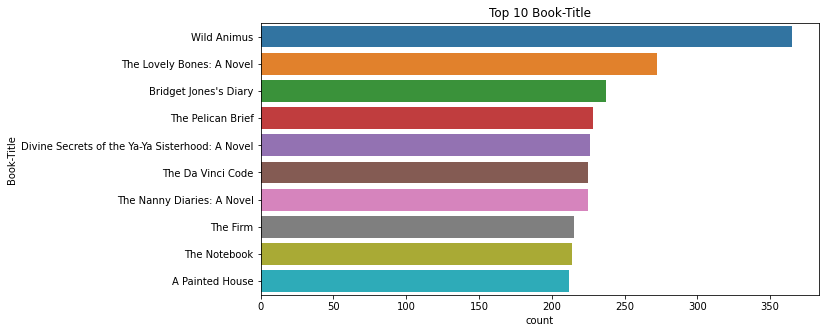

In [ ]:
# Top 10 Books
plt.figure(figsize=(10,5))
sns.countplot(y='Book-Title',data=df, order=pd.value_counts(df['Book-Title']).iloc[:10].index)
plt.title('Top 10 Book-Title')
plt.show()



*   The top most book title found is Wild Animus.
*   Wild Animus is present in 365 rows


In [ ]:
# unique Authors count
df['Book-Author'].nunique()

4249

In [ ]:
# Top 10 Book Authors
df['Book-Author'].value_counts().head(10)

Nora Roberts          3958
Stephen King          3533
James Patterson       2078
Mary Higgins Clark    1938
Danielle Steel        1844
Dean R. Koontz        1791
John Grisham          1760
V.C. Andrews          1542
Sue Grafton           1465
Tom Clancy            1444
Name: Book-Author, dtype: int64

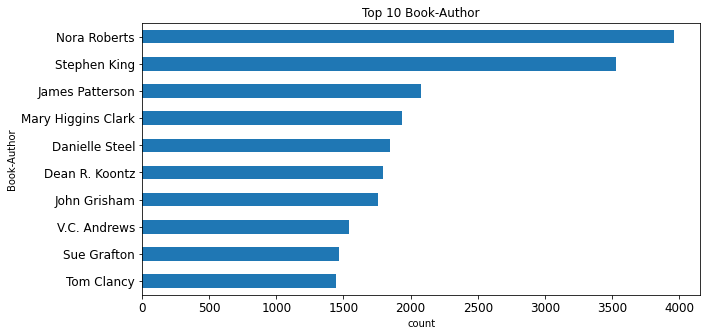

In [ ]:
# Top 10 Book Authors
fig, axes = plt.subplots(1, 1, figsize=(10, 5)) 
_ = df['Book-Author'].value_counts().head(10).sort_values(ascending=True).plot(kind = 'barh', title='Top 10 Book-Author', fontsize=12)
plt.xlabel('count')
plt.ylabel('Book-Author')
plt.show()

*   The top most author found is Nora Roberts.
*   3958 Books written By Nora Roberts books in Data Frmae.

In [ ]:
# COunt of Unique Publisher
df['Publisher'].nunique()

1075

In [ ]:
# Top 10 Publshers
df['Publisher'].value_counts().head(10).sort_values(ascending=True)

Dell                         5809
Jove Books                   6007
Signet Book                  6149
Avon                         6363
Bantam                       6581
Bantam Books                 7063
Warner Books                 7866
Berkley Publishing Group     9690
Ballantine Books            10368
Pocket                      10786
Name: Publisher, dtype: int64

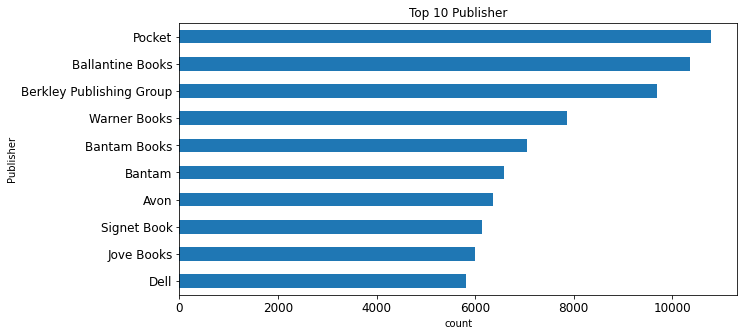

In [ ]:
# Top 10 Publishers
fig, axes = plt.subplots(1, 1, figsize=(10, 5)) 
_ = df['Publisher'].value_counts().head(10).sort_values(ascending=True).plot(kind = 'barh', title='Top 10 Publisher', fontsize=12)
plt.xlabel('count')
plt.ylabel('Publisher')
plt.show()

*   The top most Publishers found is Pocket.
*   10786 Books Published By Pocket.

In [ ]:
# year of publication Ratio
df['Year-Of-Publication'].value_counts().head(10)

2002    19817
2001    15834
2003    15341
1999    14913
2000    13654
1996    12439
1995    12183
1998    11607
1997    11217
1994     9230
Name: Year-Of-Publication, dtype: int64

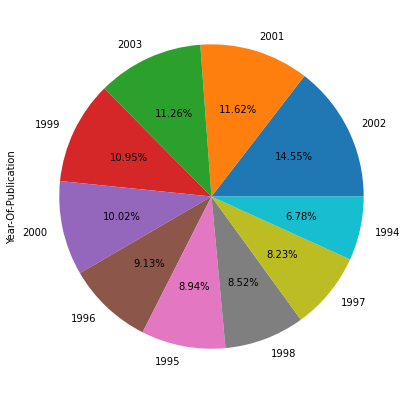

In [ ]:
# year of Publication Ratio
fig= plt.figure(figsize=(15,7))
df['Year-Of-Publication'].value_counts().head(10).plot(kind='pie', autopct='%1.2f%%')
plt.show()

*  Most books were published in the year of 2002.

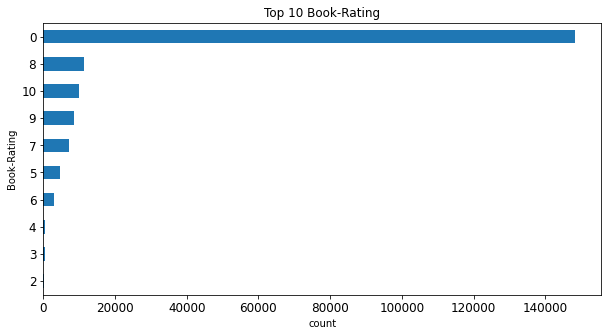

In [ ]:
# Checking the ratings.
fig, axes = plt.subplots(1, 1, figsize=(10, 5)) 
_ =df['Book-Rating'].value_counts().head(10).sort_values(ascending=True).plot(kind = 'barh', title='Top 10 Book-Rating', fontsize=12)
plt.xlabel('count')
plt.ylabel('Book-Rating')
plt.show()

*  Highest rating is 8 out of 10.
*  Lowest rating is 1 out of 10.
*  Most of the people haven't given the ratings.